In [4]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
import librosa
import matplotlib.pyplot as plt
from tensor_hero.visualization import slice_notes
from tensor_hero.preprocessing.data import __remove_release_keys, __remove_modifiers
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.visualization import __create_scatter_axes, plot_chart
from tensor_hero.onset import ninos, get_10ms_onset_frames
# Load candidate audio segments

# Get a few 10 second song segments to try out (10 seconds defined below)
anberlin_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Anberlin - The Feel Good Drag'
notes_array_anberlin = chart2tensor(anberlin_path / 'notes.chart')
notes_array_anberlin = __remove_modifiers(__remove_release_keys(notes_array_anberlin))
anberlin, sr_anberlin = librosa.load(str(anberlin_path / 'other.wav'))
anberlin = anberlin[sr_anberlin*10:sr_anberlin*20]
notes_array_anberlin = slice_notes(notes_array_anberlin, 10, 20)

infected_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Bad Religion - Infected'
notes_array_infected = chart2tensor(infected_path / 'notes.chart')
notes_array_infected = __remove_modifiers(__remove_release_keys(notes_array_infected))
infected, sr_infected = librosa.load(str(infected_path / 'other.wav'))
infected = infected[sr_infected*60:sr_infected*70]
notes_array_infected = slice_notes(notes_array_infected, 60, 70)

number_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Ben Harper and Relentless7 - Number with No Name'
notes_array_number = chart2tensor(number_path / 'notes.chart')
notes_array_number = __remove_modifiers(__remove_release_keys(notes_array_number))
number, sr_number = librosa.load(str(number_path / 'other.wav'))
number = number[sr_number*100:sr_number*110]
notes_array_number = slice_notes(notes_array_number, 100, 110)

soothsayer_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Buckethead - Soothsayer (xX760Xx)'
notes_array_soothsayer = chart2tensor(soothsayer_path / 'notes.chart')
notes_array_soothsayer = __remove_modifiers(__remove_release_keys(notes_array_soothsayer))
soothsayer, sr_soothsayer = librosa.load(str(soothsayer_path / 'other.wav'))
soothsayer = soothsayer[sr_soothsayer*280:sr_soothsayer*290]
notes_array_soothsayer = slice_notes(notes_array_soothsayer, 280, 290)

misirlou_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Dick Dale - Misirlou'
notes_array_misirlou = chart2tensor(misirlou_path / 'notes.chart')
notes_array_misirlou = __remove_modifiers(__remove_release_keys(notes_array_misirlou))
misirlou, sr_misirlou = librosa.load(str(misirlou_path / 'other.wav'))
misirlou = misirlou[sr_misirlou*70:sr_misirlou*80]
notes_array_misirlou = slice_notes(notes_array_misirlou, 70, 80)

littlewing_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Jimi Hendrix - Little Wing'
notes_array_littlewing = chart2tensor(littlewing_path / 'notes.chart')
notes_array_littlewing = __remove_modifiers(__remove_release_keys(notes_array_littlewing))
littlewing, sr_littlewing = librosa.load(str(littlewing_path / 'other.wav'))
littlewing = littlewing[sr_littlewing*90:sr_littlewing*100]
notes_array_littlewing = slice_notes(notes_array_littlewing, 90, 100)

In [261]:
def load_song(song_dir):
    '''Loads audio, sr, and notes array from song_dir, returns audio and notes array sliced
    into 4 second chunks

    Args:
        song_dir (Path): Path to song directory containing both notes.chart and other.wav
    
    Returns:
        notes_arrays (2D numpy array): Matrix of numpy arrays where each row is a 4 second notes array
        audio_segments (2D numpy array): Matrix of raw audio arrays where each row is 4 seconds of audio
        sr (int): sample rate
    '''
    # Get simplified notes array and audio
    notes_array = chart2tensor(song_dir / 'notes.chart')
    notes_array = __remove_modifiers(__remove_release_keys(notes_array))
    audio, sr = librosa.load(str(song_dir / 'other.wav'))
 
    # Pad audio and notes array to be divisible by 4 seconds
    audio = np.pad(audio, (0, (sr*4) - audio.shape[0]%(sr*4)), 'constant', constant_values=0)
    notes_array = np.pad(notes_array, (0, 400 - notes_array.shape[0]%400), 'constant', constant_values=0)

    # Slice into segments
    audio_segments = np.array([audio[(i*4)*sr:(i+1)*4*sr] for i in range(int(audio.shape[0]/(sr*4)))])
    notes_arrays = np.array([notes_array[i*400:(i+1)*400] for i in range(int(notes_array.shape[0]/400))])
    return audio_segments, notes_arrays, sr

audio_segments, notes_arrays, sr = load_song(littlewing_path)
print(audio_segments.shape)
print(notes_arrays.shape)


(43, 88200)
(43, 400)


In [258]:
notes_arrays

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
audio, sr= librosa.load(str(Path.cwd() / 'mediumhall.mp3'))

In [251]:
import sounddevice as sd
import numpy as np
import math

def compute_spectrogram(audio, sr):
    resampled = librosa.resample(audio, sr, 44100)
    spec = librosa.feature.melspectrogram(resampled, 44100, n_fft=2048*2, hop_length=441, n_mels=512, power=2, fmax = sr/2)
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def ninos(audio, sr, spec=None, gamma=0.94):
    '''Calculates Normalized Identifying Note Onsets based on Spectral Sparsity (NINOS)
    over time for audio.
   
    Implementation as described in 
        https://www.eurasip.org/Proceedings/Eusipco/Eusipco2016/papers/1570256369.pdf 
        
    Each time bin in the returned frame corresponds to approx 4.6ms of audio data.

    Args:
        audio (1D numpy array): Raw audio samples
        sr (int): sample rate
        gamma (float in (0,1]): Proportion of frequency bins to keep
    
    Returns:
        ninos (1D numpy array): Normalized inverse-sparsity measure
        J (int): Number of retained frequency bins
        hop_length (int): Hop length used to compute spectrogram
        
    '''
    # Define spectrogram parameters
    if sr == 22050:
        n_fft = 1024
        hop_length = 102
    elif sr == 44100:
        n_fft = 2048
        hop_length = 205
    else:
        raise ValueError(f'ERROR: sr = {sr}, sr must be either 22050 or 44100')    

    if spec is None:
        # Compute spectrogram if not provided
        spec = np.abs(librosa.stft(audio, n_fft, hop_length))
    
    # Order by magnitude within each time bin
    spec = np.sort(spec, axis=0)
    
    # Remove the highest energy frames, cut down by factor of gamma
    J = math.floor(spec.shape[0]*gamma)
    spec = spec[:J,:]
    
    # Compute squared l2 norm and l4 norm of spec along time axis
    l2_squared = np.square(np.linalg.norm(spec, ord=2, axis=0))
    l4 = np.linalg.norm(spec, ord=4, axis=0)
    
    # Convert to NINOS
    ninos = l2_squared / ((J**(1/4))*l4)

    return ninos, J, hop_length

def get_properties(audio, sr, p=0.05, gamma=0.94, hop_len=441, use_filtered_spec=True, _print=False):
    resampled = librosa.resample(audio, sr, 44100)

    # log-mel spectrogram, 10ms time bins
    spec = librosa.feature.melspectrogram(resampled, 44100, n_fft=2048*2, hop_length=hop_len, n_mels=512, power=2, fmax = sr/2)
    # spec = librosa.feature.melspectrogram(audio, 22050, n_fft=2048, hop_length=220, power=2)
    spec = librosa.power_to_db(spec, ref=np.max)
    if use_filtered_spec:
        spec = filter_spec_by_amplitude(spec, p=p)
    
    # mfcc, 10ms time bins
    # mfcc = librosa.feature.mfcc(resampled, sr, n_mfcc=20, hop_length=441)    
    mfcc = librosa.feature.mfcc(S=spec, n_mfcc=20)    

    # odf, 4.6ms time bins
    odf, _, _ = ninos(audio, sr, spec=spec, gamma=gamma)
    # odf, _, _ = ninos(audio, sr, spec=None)

    # energy, 4.6ms time bins
    # energy = librosa.feature.rms(audio, hop_length=hop_length)[0]
    energy = librosa.feature.rms(S=spec, frame_length=1022)[0]

    # odf_energy = odf*energy at each timestep
    odf_energy = np.multiply(odf, energy)
    
    # log energy novelty
    # https://musicinformationretrieval.com/novelty_functions.html
    log_energy = np.log1p(10*energy)
    log_energy_diff = np.zeros_like(log_energy)
    log_energy_diff[1:] = np.diff(log_energy)
    log_energy_novelty = np.max([np.zeros_like(log_energy_diff), log_energy_diff], axis=0)

    if _print:
        print(f'log energy novelty shape: {log_energy_novelty.shape}')
        print(f'spec shape: {spec.shape}')
        print(f'mfcc shape: {mfcc.shape}')
        print(f'odf shape: {odf.shape}')
        print(f'energy shape: {energy.shape}')
        print(f'odf_energy shape: {odf_energy.shape}')
    
    # spectral novelty
    # spectral_novelty = librosa.onset.onset_strength(audio, sr, hop_length=hop_length)
    spectral_novelty = librosa.onset.onset_strength(S=spec)

    return spec, mfcc, odf, energy, odf_energy, log_energy_novelty, spectral_novelty

spec, mfcc, odf, energy, odf_energy, log_energy_novelty, spectral_novelty = get_properties(number[-sr_number*4:], 
                                                                                           sr_number,
                                                                                           p=0.99, gamma=0.94, _print=True)

log energy novelty shape: (401,)
spec shape: (512, 401)
mfcc shape: (20, 401)
odf shape: (401,)
energy shape: (401,)
odf_energy shape: (401,)


In [1]:
from tensor_hero.onset import onset_select, onset_frames_to_time
import mir_eval

def onset_frame_f1(gt, c, sr, hop_len):
    gt = np.array(onset_frames_to_time(gt, 44100, 441))
    c = np.array(onset_frames_to_time(c, sr=sr, hop_len=hop_len))
    f1, _, _ = mir_eval.onset.f_measure(gt, c)
    return f1

def plot_properties(spec=None, mfcc=None, ground_truth=None, odf=None, energy=None, 
                    odf_energy=None, log_energy_novelty=None, spectral_novelty=None,
                    onset_params = [2, 3, 7, 1, 3, 0.01], SHOW=True, hop_len=None, sr=None, 
                    suptitle='Properties'):
    '''
    Plots Guitar Hero charts and spectrograms using matplotlib.
    
    Can also be used to plot spectrograms without notes, just fill in the audio arg without
    ground_truth or candidate.

    ~~~~ ARGUMENTS ~~~~
    - ground_truth (list of int): ground truth notes array
    - candidate (list of int): candidate notes array
    - audio (2D numpy matrix): spectrogram
    - SHOW (bool): If true, will show the generated plot in place

    ~~~~ RETURNS ~~~~
    - matplotlib figure: contains the full generated plot
    '''
    num_subplots = int(spec is not None) + int(mfcc is not None) \
                   + int(tempogram is not None) \
                   + int(ground_truth is not None) + int(odf is not None) \
                   + int(energy is not None) + int(odf_energy is not None) \
                   + int(log_energy_novelty is not None) + int(spectral_novelty is not None) \
                   + 4
    
    fig, axes = plt.subplots(num_subplots)
    # fig.set_size_inches(min(len(ground_truth)/40, 900), 3*num_subplots)
    fig.set_size_inches(25, 3*num_subplots)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(suptitle, y=0.93, fontsize=20)
    
    # Transformations and normalizations
    odf_sum_energy = odf+energy
    log_energy_novelty_mult_odf_energy = np.multiply(log_energy_novelty, odf_energy)
    d_energy = librosa.feature.delta(energy)
    d_energy_mult_energy = np.multiply(d_energy, energy)

    odf_unnormalized = -odf
    odf = -(odf - np.min(odf)) / np.max(odf - np.min(odf)) + 1

    energy = -(energy - np.min(energy)) / np.max(energy - np.min(energy)) + 1
    d_energy = -(d_energy - np.min(d_energy)) / np.max(d_energy - np.min(d_energy)) + 1
    d_energy_mult_energy = np.multiply(d_energy, energy)
    d_energy_mult_energy = (d_energy_mult_energy - np.min(d_energy_mult_energy)) \
                            / np.max(d_energy_mult_energy - np.min(d_energy_mult_energy))

    odf_sum_energy = -(odf_sum_energy - np.min(odf_sum_energy)) / np.max(odf_sum_energy - np.min(odf_sum_energy)) + 1
    odf_energy = np.multiply(odf, energy)
    odf_energy = (odf_energy - np.min(odf_energy)) / np.max(odf_energy - np.min(odf_energy))
    log_energy_novelty = (log_energy_novelty - np.min(log_energy_novelty)) / np.max(log_energy_novelty - np.min(log_energy_novelty))
    spectral_novelty = (spectral_novelty - np.min(spectral_novelty)) / np.max(spectral_novelty - np.min(spectral_novelty))
    log_energy_novelty_mult_odf_energy = (log_energy_novelty_mult_odf_energy - np.min(log_energy_novelty_mult_odf_energy)) \
                                            / np.max(log_energy_novelty_mult_odf_energy - np.min(log_energy_novelty_mult_odf_energy))
    
    # Select onsets for odf, energy, and odf_energy
    odf_onsets = onset_select(odf, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_unnormalized_onsets = onset_select(odf_unnormalized, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    energy_onsets = onset_select(energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_energy_onsets = onset_select(odf_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    log_energy_novelty_onsets = onset_select(log_energy_novelty, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    spectral_novelty_onsets = onset_select(spectral_novelty, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_sum_energy_onsets = onset_select(odf_sum_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    log_energy_novelty_mult_odf_energy_onsets = onset_select(log_energy_novelty_mult_odf_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    d_energy_onsets = onset_select(d_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    d_energy_mult_energy_onsets = onset_select(d_energy_mult_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])

    # get onsets from chart, convert to same frame width as onsets described above
    gt_onsets = np.where(ground_truth>0)[0]
    expansion_factor = odf.shape[0] / ground_truth.shape[0]
    gt_onsets = [x*expansion_factor for x in gt_onsets]
    
    # Compute f1 scores of onsets, to be displayed with title
    odf_f1 = onset_frame_f1(gt_onsets, odf_onsets, sr=sr, hop_len=hop_len)
    odf_unnormalized_f1 = onset_frame_f1(gt_onsets, odf_unnormalized_onsets, sr=sr, hop_len=hop_len)
    energy_f1 = onset_frame_f1(gt_onsets, energy_onsets, sr=sr, hop_len=hop_len)
    odf_energy_f1 = onset_frame_f1(gt_onsets, odf_energy_onsets, sr=sr, hop_len=hop_len)
    log_energy_novelty_f1 = onset_frame_f1(gt_onsets, log_energy_novelty_onsets, sr=sr, hop_len=hop_len)
    spectral_novelty_f1 = onset_frame_f1(gt_onsets, spectral_novelty_onsets, sr=sr, hop_len=hop_len)
    odf_sum_energy_f1 = onset_frame_f1(gt_onsets, odf_sum_energy_onsets, sr=sr, hop_len=hop_len)
    log_energy_novelty_mult_odf_energy_f1 = onset_frame_f1(gt_onsets, odf_onsets, sr=sr, hop_len=hop_len)
    d_energy_f1 = onset_frame_f1(gt_onsets, d_energy_onsets, sr=sr, hop_len=hop_len)
    d_energy_mult_energy_f1 = onset_frame_f1(gt_onsets, d_energy_mult_energy_onsets, sr=sr, hop_len=hop_len)
    
    # Get number of gt onsets to compute saturation
    num_gt_onsets = len(gt_onsets) 

    ax_idx = 0 # Will be increased with each subsequent subplot
    
    if spec is not None:
        axes[ax_idx].imshow(spec, aspect='auto', origin='lower')
        axes[ax_idx].set_title('spec')
        ax_idx += 1
    
    if mfcc is not None:
        axes[ax_idx].imshow(mfcc, aspect='auto', origin='lower')
        axes[ax_idx].set_title('mfcc')
        ax_idx += 1

    if ground_truth is not None:
        __create_scatter_axes(ground_truth, axes[ax_idx])
        axes[ax_idx].set_title('Ground Truth')
        ax_idx += 1
    
    if odf_unnormalized is not None:
        axes[ax_idx].plot(odf_unnormalized)
        axes[ax_idx].margins(0)
        
        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in odf_unnormalized_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'odf_unnormalized | f1 = {odf_unnormalized_f1:.2f} | saturation = {odf_unnormalized_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if odf is not None:
        axes[ax_idx].plot(odf)
        axes[ax_idx].margins(0)
        
        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in odf_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'odf | f1 = {odf_f1:.2f} | saturation = {odf_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1
    
    if energy is not None:
        axes[ax_idx].plot(energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'energy | f1 = {energy_f1:.2f} | saturation = {energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if d_energy is not None:
        axes[ax_idx].plot(d_energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('d_energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in d_energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'd_energy | f1 = {d_energy_f1:.2f} | saturation = {d_energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if d_energy_mult_energy is not None:
        axes[ax_idx].plot(d_energy_mult_energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('d_energy_mult_energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in d_energy_mult_energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'd_energy_mult_energy | f1 = {d_energy_mult_energy_f1:.2f} | saturation = {d_energy_mult_energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    # odf sum energy
    if odf_sum_energy is not None:
        axes[ax_idx].plot(odf_sum_energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('odf_sum_energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in odf_sum_energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'odf_sum_energy | f1 = {odf_sum_energy_f1:.2f} | saturation = {odf_sum_energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if odf_energy is not None:
        axes[ax_idx].plot(odf_energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('odf_energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in odf_energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'odf_energy | f1 = {odf_energy_f1:.2f} | saturation = {odf_energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if log_energy_novelty is not None:
        axes[ax_idx].plot(log_energy_novelty)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('log_energy_novelty')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in log_energy_novelty_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'log_energy_novelty | f1 = {log_energy_novelty_f1:.2f} | saturation = {log_energy_novelty_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if spectral_novelty is not None:
        axes[ax_idx].plot(spectral_novelty)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('spectral_novelty')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in spectral_novelty_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'spectral_novelty | f1 = {spectral_novelty_f1:.2f} | saturation = {spectral_novelty_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    if log_energy_novelty_mult_odf_energy is not None:
        axes[ax_idx].plot(log_energy_novelty_mult_odf_energy)
        axes[ax_idx].margins(0)
        axes[ax_idx].set_title('log_energy_novelty_mult_odf_energy')

        # Plot onsets
        for o in gt_onsets:
            axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
        for o in log_energy_novelty_mult_odf_energy_onsets:
            axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
        axes[ax_idx].set_title(f'log_energy_novelty_mult_odf_energy | f1 = {log_energy_novelty_mult_odf_energy_f1:.2f} | saturation = {log_energy_novelty_mult_odf_energy_onsets.shape[0]/num_gt_onsets:.2f}')

        ax_idx += 1

    fig.align_xlabels(axes)
    
    if SHOW:
        plt.show()
    
    # Construct statistics dictionaries
    onset_f1s = {
        'odf_unnormalized' : odf_unnormalized_f1,
        'odf' : odf_f1,
        'energy' : energy_f1,
        'd_energy' : d_energy_f1,
        'd_energy_mult_energy' : d_energy_mult_energy_f1,
        'odf_sum_energy' : odf_sum_energy_f1,
        'odf_energy' : odf_energy_f1,
        'log_energy_novelty' : log_energy_novelty_f1,
        'spectral_novelty' : spectral_novelty_f1,
        'log_energy_novelty_mult_odf_energy' : log_energy_novelty_mult_odf_energy_f1,
    }
    onset_saturations = {
        'odf_unnormalized' : odf_unnormalized_onsets.shape[0]/num_gt_onsets,
        'odf' : odf_onsets.shape[0]/num_gt_onsets,
        'energy' : energy_onsets.shape[0]/num_gt_onsets,
        'd_energy' : d_energy_onsets.shape[0]/num_gt_onsets,
        'd_energy_mult_energy' : d_energy_mult_energy_onsets.shape[0]/num_gt_onsets,
        'odf_sum_energy' : odf_sum_energy_onsets.shape[0]/num_gt_onsets,
        'odf_energy' : odf_energy_onsets.shape[0]/num_gt_onsets,
        'log_energy_novelty' : log_energy_novelty_onsets.shape[0]/num_gt_onsets,
        'spectral_novelty' : spectral_novelty_onsets.shape[0]/num_gt_onsets,
        'log_energy_novelty_mult_odf_energy' : log_energy_novelty_mult_odf_energy_onsets.shape[0]/num_gt_onsets,
    }
    return fig, onset_f1s, onset_saturations

_, _, _ = plot_properties(spec=spec, mfcc=mfcc, 
                    ground_truth=notes_array_number[-401:], odf=odf, energy=energy, 
                    odf_energy=odf_energy, log_energy_novelty=log_energy_novelty,
                    spectral_novelty=spectral_novelty, SHOW=True, hop_len=220,
                    sr=sr_soothsayer)

ModuleNotFoundError: No module named 'tensor_hero'

Find how many elements in a spectrogram are above t*max(spec)

t -> "threshold"

spec shape: (512, 1001)
mfcc shape: (20, 1001)
tempogram shape: (384, 1001)
odf shape: (2162,)
energy shape: (1, 2162)
odf_energy shape: (1, 2162)


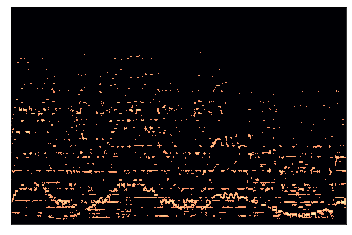

In [96]:
import librosa.display

spec, mfcc, tempogram, odf, energy, odf_energy, hop_length_soothsayer = get_properties(soothsayer, sr_soothsayer)

def filter_spec_by_amplitude(spec, p):
    '''Filters out (1-p)% of elements with the smallest values from spec

    Args:
        spec (2D numpy array): spectrogram or other 2D matrix
        p (float in [0, 1]): desired portion of spec to keep
    
    Returns:
        (2D numpy array): spec with low values filtered out
    '''
    num_elements = np.size(spec)
    num_to_keep = int(p*num_elements)
    t_val = np.flip(np.sort(spec, axis=None))[num_to_keep]  # Threshold
    spec[spec < t_val] = np.min(spec)
    return spec
    
spec = filter_spec_by_amplitude(spec, 0.05)
    
# t = 0.6
# t_val = t*(np.max(spec) - np.min(spec)) + np.min(spec)
# print(t_val)

# spec_filtered = spec.copy()
# spec_filtered[spec_filtered < t_val] = np.min(spec)

librosa.display.specshow(spec)

In [239]:
sd.play(number[-4*sr_number:], sr_number)

In [ ]:
def analyze_audio_onsets(audio, sr, notes_array, p=0.99, gamma=0.94, onset_params=[2, 3, 7, 1, 3, 0.01], show_plot=True, 
                         hop_len=None, suptitle='Properties', use_filtered_spec=True, print_odf_shapes=False):
    
    # Get ODF functions
    spec, mfcc, odf, energy, odf_energy, \
    log_energy_novelty, spectral_novelty = get_properties(audio, sr=sr, p=p, gamma=gamma, 
                                                          hop_len=hop_len, _print=print_odf_shapes,
                                                          use_filtered_spec=use_filtered_spec)
    
    # Plot and gather performance statistics
    fig, onset_f1s, onset_saturations = plot_properties(spec=spec, mfcc=mfcc, ground_truth=notes_array, odf=odf, 
                                                        energy=energy, odf_energy=odf_energy, 
                                                        log_energy_novelty=log_energy_novelty, spectral_novelty=spectral_novelty, 
                                                        SHOW=show_plot, hop_len=hop_len, sr=sr, suptitle=suptitle,
                                                        onset_params=onset_params)
    
    summary_statistics = {
        'onset_f1s' : onset_f1s,
        'onset_saturations' : onset_saturations,
    }
    
    return summary_statistics